In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport new_CCA
%aimport sample_gen
from scipy.stats import multivariate_normal
from collections import defaultdict
%aimport cca_compare

Populating the interactive namespace from numpy and matplotlib


# Creating test distribution

In [631]:
n_bands = 10
n_samples = 1000
d1 = sample_gen.create_distribution(n_bands,mean_std_scale=0.3,std=1)
d2 = sample_gen.create_distribution(n_bands,mean_std_scale=1,std=2,std_scale=0.1)
X = d1.rvs(n_samples)
Y = X+d2.rvs(n_samples)

# Code for testing CCA algorithms

In [632]:
# Generate samples
def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y

# Print info about cca
def cca_info(X,Y, A, B):
    
    prev_u = None
    prev_v = None
    
    for i,(a,b) in enumerate( zip(A.T,B.T) ):
        print('{} cannonical variates pair'.format(i+1))
                
        u = np.dot( X,a )
        v = np.dot( Y,b )

        if prev_u is not None and prev_v is not None:
            print('prev corrcoef:\n{: <10.4f}{: <10.4f}\n{: <10.4f}{: <10.4f}'.format( 
                np.corrcoef(u,prev_u)[0,1], np.corrcoef(u,prev_v)[0,1],
                np.corrcoef(v,prev_u)[0,1], np.corrcoef(v,prev_v)[0,1]
            ))
        prev_u = u
        prev_v = v

        print('corrcoef: {:.4f}'.format(np.corrcoef(u,v)[0,1]))

        # Fit u more tightly to v
        reg = LinearRegression()
        reg.fit(u[:,np.newaxis],v)
        new_u = reg.predict(u[:,np.newaxis])

        plot(new_u[:10],'C0-',label='u')
        plot(u[:10],'C0--')
        plot(v[:10],'C1',label='v')
        legend()
        show()
        
def random_subsample(sample_size,*args):
    ret = []
    ids = np.array([i for i in range(len(args[0]))])
    np.random.shuffle(ids)
    
    for arg in args:
        ret.append(np.array(arg)[ids][:sample_size])
        
    return ret

nastyCorr = None
nastyX = None
nastyY = None

# Compare CCA
def cca_compare(X,Y, funcs_dict, x_samples = 20, n_probas = 10,train_eval=False):
    
    func_labels = list(funcs_dict.keys())
    funcs = [funcs_dict[i] for i in func_labels]
    
    sample_sizes = []
    
    correlations_mean = defaultdict(list)
    correlations_max = defaultdict(list)
    correlations_min = defaultdict(list)
    
    for sample_size in np.linspace(int(X.shape[0]*0.2),X.shape[0],x_samples).astype(np.int):
        sample_sizes.append(sample_size)
        
        for func in funcs:

            corr_pack_mean = []
            corr_pack_max = []
            corr_pack_min = []
            
            for n_proba in range(n_probas):
                corr_pack = []
            
                Xs,Ys = random_subsample(sample_size,X,Y)
                A,B = func(Xs,Ys)
            
                for i,(a,b) in enumerate( zip(A.T,B.T) ):
                    if train_eval:
                        u = np.dot( Xs,a )
                        v = np.dot( Ys,b )
                    else:
                        u = np.dot( X,a )
                        v = np.dot( Y,b )
                    corr_pack.append( np.abs( np.corrcoef(u,v)[0,1] ) )

                global nastyCorr
                if np.array(corr_pack).max() > 0 and (nastyCorr is None or nastyCorr > np.array(corr_pack).max() ):
                    global nastyX
                    global nastyY
                    global nastyCorr
                    nastyX = Xs
                    nastyY = Ys
                    nastyCorr = np.array(corr_pack).max()
                    print("nastyCorr: {}".format(nastyCorr))
                    
                corr_pack_mean.append(corr_pack)

            correlations_min[func].append( np.percentile(corr_pack_mean,1,axis=0) )
            correlations_mean[func].append( np.percentile(corr_pack_mean,50,axis=0) )
            correlations_max[func].append( np.percentile(corr_pack_mean,99,axis=0) )
    
    corr_by_func_min = defaultdict(lambda: defaultdict(list))
    corr_by_func_mean = defaultdict(lambda: defaultdict(list))
    corr_by_func_max = defaultdict(lambda: defaultdict(list))
    
    for func_id,func in enumerate(funcs):
        for component_id, component_corr in enumerate( np.array( correlations_min[func] ).T ):
            corr_by_func_min[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_mean[func] ).T ):
            corr_by_func_mean[component_id][func_id] = component_corr
        for component_id, component_corr in enumerate( np.array( correlations_max[func] ).T ):
            corr_by_func_max[component_id][func_id] = component_corr
        
    for component_id in corr_by_func_mean.keys():
        for func_i,(func,label) in enumerate( zip(funcs,func_labels) ):
            
            if func_i not in corr_by_func_mean[component_id]:
                continue
                
            color = 'C{}'.format(func_i)
            
            min_x  = corr_by_func_min[component_id][func_i]
            mean_x = corr_by_func_mean[component_id][func_i]
            max_x  = corr_by_func_max[component_id][func_i]
            
            plot(sample_sizes, mean_x,color,label=label)
            fill_between(sample_sizes,min_x,max_x,facecolor=color,alpha=0.1)
        
        grid(True)
        title('Comparison of CCA. Band {}'.format(component_id))
        xlabel("sub-Sample size")
        ylabel("Correlation")
        legend()
        show()

<ipython-input-632-f41b1bc6de61>:94: SyntaxWarning: name 'nastyCorr' is used prior to global declaration
  global nastyCorr


# CCA from sklearn

In [633]:
from sklearn.cross_decomposition import CCA
from new_CCA import cca
def sklearn_cca(X,Y,n_components=10):
    cca_instance = CCA(n_components=n_components)
    cca_instance.fit(X,Y)    
    return cca_instance.x_rotations_, cca_instance.y_rotations_

## CCA test fitness

In [634]:
a, b, r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

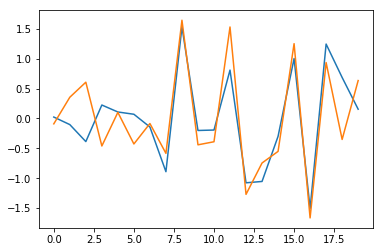

In [635]:
plot(u[:20,0]-u[:20,0].mean())
plot(v[:20,0]-v[:20,0].mean());

In [636]:
from scipy.linalg import sqrtm

# Correlation function
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

In [1018]:
x = X
y = Y

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]

xy_sum = np.transpose(x) @ y
xx_sum = np.transpose(x) @ x
yy_sum = np.transpose(y) @ y
n = np.shape(x)[0]

xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


xx_cov_sqrt_inv = np.linalg.inv( sqrtm(xx_cov) )
yy_cov_sqrt_inv = np.linalg.inv( sqrtm(yy_cov) )

u_mat = xx_cov_sqrt_inv @ xy_cov @ np.linalg.inv(yy_cov) @ xy_cov.T @ xx_cov_sqrt_inv
u_eigvals,u_eigvecs = np.linalg.eig(u_mat)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

# Sort eigenvectors by their eigenvalues
# The hypothisis here is that correlation is bigger if eigenvalue of eigenvector is bigger
u = u_eigvecs.T[sorted([i for i in range(len(u_eigvals))], key=lambda x: -u_eigvals[x])]
v = v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

a = (u @ xx_cov_sqrt_inv).T
b = (v @ yy_cov_sqrt_inv).T

regressions = np.array( [ calc_linear_regression(n,a[:,i],b[:,i],x_sum, y_sum, xy_sum, xx_sum ) for i in range(a.shape[1]) ] )
a = a*regressions[:,1]

u = np.dot( X,a )
v = np.dot( Y,b )

# apply intercept
# u = ( u.T + regressions[:,0,np.newaxis] ).T

u_var  = np.diagonal( a.T @ xx_cov @ a )
v_var  = np.diagonal( b.T @ yy_cov @ b )
uv_cov = np.diagonal( a.T @ xy_cov @ b )

m_var = (u_var + v_var - 2*uv_cov)

u_mean = np.ravel( a.T @ x_sum/n )
v_mean = np.ravel( b.T @ y_sum/n )
m_mean = u_mean-v_mean

# Weights are probabilities of being unchanged
w = (1-stats.chi2.cdf( (m**2).sum(axis=1) , 10, 0 ))[:,np.newaxis]

print('first pair corr: {:.2f}'.format(np.corrcoef(u[:,0],v[:,0])[0,1]))

first pair corr: 0.90


In [1053]:
xy_sum_w = np.transpose(x) @ (y*w)
xx_sum_w = np.transpose(x) @ (x*w)
yy_sum_w = np.transpose(x) @ (x*w)
x_sum_w = np.sum(x*w,axis=0)[:,np.newaxis]
y_sum_w = np.sum(y*w,axis=0)[:,np.newaxis]

# Possible objectives:
## 1. calculate std of M
## 2. calcualte mean of M

# 1. $Var[U-V]$

In [638]:
u_var  = np.diagonal( a.T @ xx_cov @ a )
v_var  = np.diagonal( b.T @ yy_cov @ b )
uv_cov = np.diagonal( a.T @ xy_cov @ b )

In [648]:
# calculation
m_var = (u_var + v_var - 2*uv_cov)

In [640]:
# check
np.ravel( [ np.var(u[:,i]-v[:,i]) for i in range(u.shape[1])] )

array([ 0.19409982,  0.20756203,  0.23345295,  0.29247061,  0.32778984,
        0.40334064,  0.45798809,  0.47371382,  0.61208765,  0.74684209])

# 2. $M[U-V]$

In [641]:
u_mean = np.ravel( a.T @ x_sum/n )
v_mean = np.ravel( b.T @ y_sum/n )
m_mean = u_mean-v_mean

In [642]:
# Check
print( np.abs( u.mean(axis=0) - u_mean ).max() )
print( np.abs( v.mean(axis=0) - v_mean ).max() )
print( (u-v).mean(axis=0) )
print( u_mean-v_mean )

1.13686837722e-12
9.66338120634e-13
[ -4.66690449e+02   2.47728071e+02  -1.17724125e+03   8.74246820e-01
   1.33826572e+02  -1.65424225e+02  -3.04640054e+02   3.18570740e+02
   6.81964663e+01  -8.30801556e+01]
[ -4.66690449e+02   2.47728071e+02  -1.17724125e+03   8.74246820e-01
   1.33826572e+02  -1.65424225e+02  -3.04640054e+02   3.18570740e+02
   6.81964663e+01  -8.30801556e+01]


# Normalization of $U - V$
## Seems pretty natural

In [643]:
m = ( (u-v)-m_mean )/np.sqrt(m_var)

In [644]:
from scipy import stats

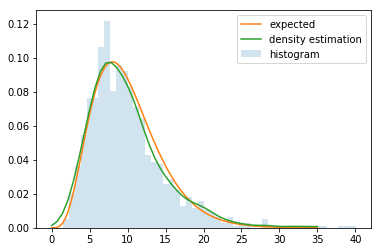

In [645]:
# X^2 distributed variable
hist( (m**2).sum(axis=1), bins = 50, normed=True, label="histogram",alpha=0.2);
plot( linspace(0,35,100), [ stats.chi2.pdf(i,10) for i in linspace(0,35,100) ], label="expected" );
plot( np.linspace(0,35), stats.gaussian_kde((m**2).sum(axis=1))(np.linspace(0,35)), label="density estimation")
axes().legend();

# Probabilities

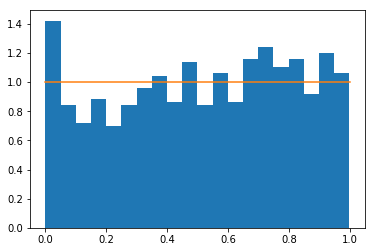

In [647]:
# Basically, Pearson's chi-squared test
# 
P = 1-stats.chi2.cdf( (m**2).sum(axis=1) , 10, 0 )
hist(P,bins=20,normed=True);
plot(np.linspace(0,1),[stats.uniform.pdf(i,0,1) for i in np.linspace(0,1)]);

# Next steps - calculate Linear Regression on v and u

# Regression formula:

$$\beta=(U^TU)^{-1}U^TV$$

where $U, V$ - cannonical pair

$$
U^TU = 
\begin{bmatrix}
    n && \sum u_i \\
    \sum u_i && \sum u_i^2
\end{bmatrix}
$$

$$
U^TV = 
\begin{bmatrix}
    \sum v_i \\
    \sum u_i v_i \\
\end{bmatrix}
$$

# Weighted regression

$$\beta=(U^T W U)^{-1}U^T W V$$

$$ W = diagonal[\{w_1,w_2,...,w_k\}] $$

$$U^T W U = 
\begin{bmatrix}
    \sum w_i && \sum w_i u_i \\
    \sum w_i u_i && \sum w_i u_i^2
\end{bmatrix}
$$

$$U^T W V = 
\begin{bmatrix}
    \sum w_i v_i \\
    \sum w_i u_i v_i \\
\end{bmatrix}
$$

# IMPORTANT!!!
### Below - formula for $\sum u_i v_i $ described through xy_sum terms and a,b

This is an essential part for calculating linear regression for target variable v and features u without actually calculating them
This represents term X^{T} y

In [1009]:
print( (u[:,0] * v[:,0]).sum() )
print( ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum() )

403103732.874
403103732.874


### Same as above, but weighted $\sum w_i u_i v_i$

In [1030]:
print( (w.T*u[:,0]*v[:,0]).sum() )
print( ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum_w ) ).sum() )

208494212.967
208494212.967


# Next step - calculate term $u^{T}u$

### $\sum_i u_i$

In [19]:
print("Original: {}".format(u[:,0].sum()) )
a[:,0] @ x_sum

Original: 233940.17863294523


array([ 233940.17863295])

### $\sum_i v_i$

In [20]:
print("Original: {}".format(v[:,0].sum()))
b[:,0] @ y_sum

Original: 952418.5591125629


array([ 952418.55911256])

### $\sum_i w_i u_i$

In [1080]:
print( (w*u[:,0,np.newaxis]).sum() )
print( a[:,0] @ x_sum_w )
print((w.T*u[:,0]).sum())

229180.76465
[ 229180.7646501]
229180.76465


### $\sum_i w_i v_i$

In [1044]:
print( (w*v[:,0,np.newaxis]).sum() )
print( b[:,0] @ y_sum_w )

470559.328313
[ 470559.32831252]


### $\sum_i u^2_i$

In [21]:
print("Original: {}".format( (u[:,0]**2).sum() ) )
((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()

Original: 54729006.17881441


54729006.178814434

### $\sum_i w_i u^2_i$

In [1055]:
print( repr( (np.ravel(w)*(u[:,0]**2)).sum() ) )

101545038.18370044


In [1054]:
((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum_w).sum()

101545038.18370043

# Assemble matrices

$$
m_1 = U^TU = 
\begin{bmatrix}
    n && \sum u_i \\
    \sum u_i && \sum u_i^2
\end{bmatrix}
$$

$$
m_2 = U^TV = 
\begin{bmatrix}
    \sum v_i \\
    \sum u_i v_i \\
\end{bmatrix}
$$

# Weighted matrices

$$m_1 = U^T W U = 
\begin{bmatrix}
    \sum w_i && \sum w_i u_i \\
    \sum w_i u_i && \sum w_i u_i^2
\end{bmatrix}
$$

$$m_2 = U^T W V = 
\begin{bmatrix}
    \sum w_i v_i \\
    \sum w_i u_i v_i \\
\end{bmatrix}
$$

In [1057]:
# Ground-truth matrices calculated directly from u and v

m1_true = np.array([
    [u[:,0].shape[0], u[:,0].sum()],
    [u[:,0].sum(), (u[:,0]*u[:,0]).sum()]
])

m2_true = np.array([
    v[:,0].sum(),
    (u[:,0]*v[:,0]).sum(),
])

m1_w_true = np.array([
    [w.sum(), (w.T*u[:,0]).sum()],
    [(w.T*u[:,0]).sum(), (w.T*u[:,0]*u[:,0]).sum()]
])

m2_w_true = np.array([
    (w.T*v[:,0]).sum(),
    (w.T*u[:,0]*v[:,0]).sum(),
])


In [1077]:
(w.T*u[:,0]).sum()

229180.76465009619

# In other terms

$$
m_1 =
\begin{bmatrix}
    n          && a^Tx_{sum} \\
    a^Tx_{sum} && grandsum[ (aa^T) \odot xx_{sum} ]
\end{bmatrix}
$$

$$
mw_1 =
\begin{bmatrix}
    \sum w_i          && a^Tx_{wsum} \\
    a^Tx_{wsum} && grandsum[ (aa^T) \odot xx_{wsum} ]
\end{bmatrix}
$$

In [1090]:
m1 = np.array([[n,(a[:,0] @ x_sum)[0]],
                  [(a[:,0] @ x_sum)[0],((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum).sum()]])

m2 = np.array([
    (b[:,0] @ y_sum)[0],
    ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum ) ).sum()
    ])

betas = np.linalg.inv(m1) @ m2
betas

array([ 466.690449,    1.      ])

In [1091]:
(a[:,0] @ x_sum_w)

array([ 229180.7646501])

In [1092]:
m1_w = np.array([[w.sum(),(a[:,0] @ x_sum_w)[0]],
                  [(a[:,0] @ x_sum_w)[0],((a[:,0,np.newaxis] @ a[:,0,np.newaxis].T) * xx_sum_w).sum()]])

m2_w = np.array([
    (b[:,0] @ y_sum_w)[0],
    ( ( a[:,0,np.newaxis] @ b[np.newaxis,:,0] ) * ( xy_sum_w ) ).sum()
    ])

check correctness

In [1095]:
# check correctness
print( 'np.abs(m1-m1_true).max() = {}'.format( np.abs(m1-m1_true).max() ))
print( 'np.abs(m2-m2_true).max() = {}'.format( np.abs(m2-m2_true).max() ))

print( 'np.abs(m1_w-m1_w_true).max() = {}'.format( np.abs(m1_w-m1_w_true).max() ))
print( 'np.abs(m2_w-m2_w_true).max() = {}'.format( np.abs(m2_w-m2_w_true).max() ))

np.abs(m1-m1_true).max() = 5.960464477539063e-08
np.abs(m2-m2_true).max() = 5.960464477539063e-08
np.abs(m1_w-m1_w_true).max() = 1.4551915228366852e-10
np.abs(m2_w-m2_w_true).max() = 2.9802322387695312e-08


# Put calculation of linear regresson into function

In [1112]:
def calc_linear_regression(n,a,b,x_sum, y_sum, xy_sum, xx_sum ):
    m1 = np.array([[n,(a @ x_sum)[0]],
                  [(a @ x_sum)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum).sum()]])
    m2 = np.array([
        (b @ y_sum)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum ) ).sum()
    ])
    return np.linalg.inv(m1) @ m2

In [1146]:
intercept,coef = calc_linear_regression(n,a[:,0],b[:,0],x_sum, y_sum, xy_sum, xx_sum )
print("My method:\t{:.10f} {:.10f}".format( intercept, coef ) )

from sklearn.linear_model import LinearRegression
skreg = LinearRegression(fit_intercept=True)
skreg.fit(u[:,0,np.newaxis],v[:,0])
print("sk-learn check:\t{:.10f} {:.10f}".format(skreg.intercept_, skreg.coef_[0] ) )

print("Mean of squares: ", ((u[:,0]*coef+intercept - v[:,0])**2).mean() )

My method:	466.6904489994 1.0000000001
sk-learn check:	466.6904489601 1.0000000002
Mean of squares:  0.194099816094


### weighted linear regression

In [1148]:
def calc_linear_regression_weighted( w_sum,a,b,x_sum_w, y_sum_w, xy_sum_w, xx_sum_w ):
    m1_w = np.array([[w_sum,(a @ x_sum_w)[0]],
                  [(a @ x_sum_w)[0],((a[:,np.newaxis] @ a[:,np.newaxis].T) * xx_sum_w).sum()]])
    m2_w = np.array([
        (b @ y_sum_w)[0],
        ( ( a[:,np.newaxis] @ b[np.newaxis,:] ) * ( xy_sum_w ) ).sum()
        ])
    return np.linalg.inv(m1_w) @ m2_w

## Check that weighted linear regression minimizes $\sum w_i (u_i w_i)^2$

In [1164]:
intercept,coef = calc_linear_regression_weighted( w_sum,a[:,0],b[:,0],x_sum_w,y_sum_w, xy_sum_w, xx_sum_w )
print("My method:\t{:.10f} {:.10f}".format( intercept, coef ) )

from sklearn.linear_model import LinearRegression
skreg = LinearRegression(fit_intercept=True)
skreg.fit(u[:,0,np.newaxis],v[:,0],np.ravel(w))
print("sk-learn check:\t{:.10f} {:.10f}".format(skreg.intercept_, skreg.coef_[0] ) )

print("Mean of squares: ", ( np.ravel(w)*((u[:,0]*coef+intercept - v[:,0])**2)).mean() )
print("Sklearn mean of squares: ", ( np.ravel(w)*((u[:,0]*skreg.coef_+skreg.intercept_ - v[:,0])**2) ).mean() )

print("Weighted sum of squares of my method is still less, so we can assume it works")

My method:	-0.0019535390 2.0532235194
sk-learn check:	474.8500679926 0.9815123720
Mean of squares:  0.533671939929
Sklearn mean of squares:  0.0575871292283
Weighted sum of squares of my method is still less, so we can assume it works


# Test new code

In [74]:
a,b,r = new_CCA.cca(X,Y)
u = np.dot( X,a )
v = np.dot( Y,b )

In [79]:
np.corrcoef((u+r)[:,1],v[:,1])[0,1]

0.87252536854435581

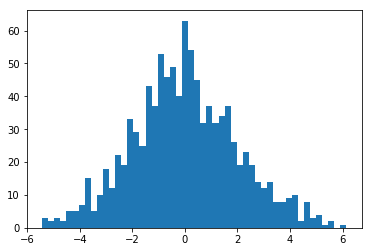

In [104]:
hist( ((u+r)-v).sum(axis=1), bins=50 );

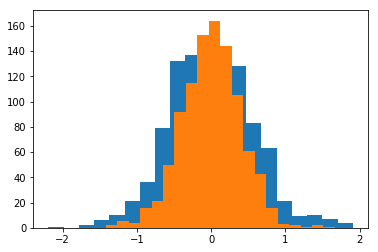

In [96]:
hist( (u+r)[:,3]-v[:,3],bins=20 );
hist( (u+r)[:,0]-v[:,0],bins=20 );

# Dump data to files for testing

In [105]:
import pandas as pd

In [106]:
target_file = "./test_files/"
pd.DataFrame(Y).to_csv("{}test_Y.csv".format(target_file),index=False,header=False)
pd.DataFrame(X).to_csv("{}test_X.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov).to_csv("{}xx_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_cov).to_csv("{}xy_cov.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov).to_csv("{}yy_cov.csv".format(target_file),index=False,header=False)

pd.DataFrame(xx_cov_sqrt_inv).to_csv("{}xx_cov_sqrt_inv.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_cov_sqrt_inv).to_csv("{}yy_cov_sqrt_inv.csv".format(target_file),index=False,header=False)

pd.DataFrame(u).to_csv("{}test_U.csv".format(target_file),index=False,header=False)
pd.DataFrame(v).to_csv("{}test_V.csv".format(target_file),index=False,header=False)

pd.DataFrame(a).to_csv("{}test_a.csv".format(target_file),index=False,header=False)
pd.DataFrame(b).to_csv("{}test_b.csv".format(target_file),index=False,header=False)
pd.DataFrame(x_sum).to_csv("{}x_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xx_sum).to_csv("{}xx_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(xy_sum).to_csv("{}xy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(yy_sum).to_csv("{}yy_sum.csv".format(target_file),index=False,header=False)
pd.DataFrame(y_sum).to_csv("{}y_sum.csv".format(target_file),index=False,header=False)

# Linear regression

# Below - temporary records

In [94]:
eigenvals,eigenvecs = np.linalg.eig( xx_sum )

E = np.diag( eigenvals )
V = eigenvecs

# E,V
# E - matrix with eigenvalues on diagonal
# V - matrix with eigenvectors

# sqrtMatrix = V * sqrt(E) * V^T

res = V @ sqrt(E) @ V.T

sqrt(E)
sqrtm(xx_cov)

v_mat = yy_cov_sqrt_inv @ xy_cov.T @ np.linalg.inv(xx_cov) @ xy_cov @ yy_cov_sqrt_inv
v_eigvals,v_eigvecs = np.linalg.eig(v_mat)

v_eigvecs.T[sorted([i for i in range(len(v_eigvals))], key=lambda x: -v_eigvals[x])]

# What about weights?
try to calculate weighted CCA and see if your predictions apply

In [923]:
weights = np.abs( np.random.normal(0.6,0.4,size=x.size) )[:,np.newaxis]

In [774]:
print('yy_cov')
print("Was:",((y-y.mean())**2).sum()/(y.size-1))
print("Begun:",( weights*np.ravel((y-y.mean())**2) ).sum()/(weights.sum()-1))

yy_cov
Was: 1.25454545455
Begun: 1.30421962605


In [775]:
print("xx_cov")
print("Was:",((x-x.mean())**2).sum()/(x.size-1))
print("Begun:",( weights*np.ravel((x-x.mean())**2) ).sum()/(weights.sum()-1))

xx_cov
Was: 0.8
Begun: 0.802308381077


In [776]:
print("xy_cov")
print("Was:",((x-x.mean())*(y-y.mean())).sum()/(y.size-1) )
print("Begun: ", (weights*np.ravel((x-x.mean())*(y-y.mean()))).sum()/(weights.sum()-1) )

xy_cov
Was: 0.3
Begun:  0.446885332427


In [773]:
np.cov(x.T,y.T)

array([[ 0.8       ,  0.3       ],
       [ 0.3       ,  1.25454545]])

In [769]:
np.cov(x.T,y.T)

array([[ 0.69040823,  0.54409609],
       [ 0.54409609,  1.29332109]])

In [905]:
weights = np.ones(y.size)[:,np.newaxis]

In [962]:
x = np.array([0,0,1,2,0,0,1,2,1,2,2])[:,np.newaxis]
y = np.array([0,2,1,0,1,1,2,4,1,2,1])[:,np.newaxis]

#y = weights[:,np.newaxis]*y
#x = weights[:,np.newaxis]*x

x_sum = np.sum(x,axis=0)[:,np.newaxis]
y_sum = np.sum(y,axis=0)[:,np.newaxis]
x_sum_w = np.sum(x*weights,axis=0)[:,np.newaxis]
y_sum_w = np.sum(y*weights,axis=0)[:,np.newaxis]
xy_sum = np.transpose(x) @ (y*weights) # Equivavlent of X^T W Y, where W - matrix with weights on diagonal, see proof below
xx_sum = np.transpose(x) @ x
yy_sum = np.transpose(y) @ y
n = np.shape(x)[0]
#n = weights.sum()
w_sum = weights.sum()

xy_cov = calc_covariance(xy_sum,x_sum,y_sum,n)
xx_cov = calc_covariance(xx_sum,x_sum,x_sum,n)
yy_cov = calc_covariance(yy_sum,y_sum,y_sum,n)


# Proof of np.transpose(x) @ (y*weights) = $X^T W Y$

In [1002]:
xy_sum - (np.transpose(x) @ np.diag( np.ravel(weights) ) @  y)

array([[ 0.]])

# Below - derivation of covariance for weighted samples

In [937]:
(weights*(x-x.mean())*(y-y.mean())).sum()/(weights.sum()-1)

0.13623914450262825

In [932]:
( (weights*x.mean()*y.mean()).sum() + ((x*y - x*y.mean() - y*x.mean())*weights).sum() )/(weights.sum()-1)

0.13623914450262861

In [966]:
( (weights*(x_sum*y_sum)/n/n).sum() + ( (x*y)*weights ).sum() + ((- x*y_sum/n)*weights).sum() - ((y*x_sum/n)*weights).sum() )/(w_sum-1)

0.13623914450262803

In [984]:
( (w_sum*(x_sum*y_sum)/n/n) + xy_sum -x_sum_w*y_sum/n -y_sum_w*x_sum/n )/(w_sum-1)

array([[ 0.13623914]])

In [1167]:
# Correlation function
def calc_covariance_weighted(xy_sum,x_sum,x_sum_w,y_sum,y_sum_w,n,w_sum):
    """
    calculate weighted covariance matrix of 2 variables
    """
    return ( (w_sum*(x_sum*y_sum)/n/n) + xy_sum -x_sum_w*y_sum/n -y_sum_w*x_sum/n )/(w_sum-1)

# Weighted linear regression formulas

# Tests

In [910]:
print("xx_cov: {}".format(xx_cov))
print("xy_cov: {}".format(xy_cov))
print("yy_cov: {}".format(yy_cov))

xx_cov: [[ 0.8]]
xy_cov: [[ 0.3]]
yy_cov: [[ 1.25454545]]


In [779]:
xy_cov

array([[ 0.39595629]])

In [780]:
yy_cov

array([[ 1.22379051]])

In [781]:
xx_cov

array([[ 0.64138314]])

In [782]:
np.cov(x.T,y.T)

array([[ 0.69040823,  0.54409609],
       [ 0.54409609,  1.29332109]])

In [783]:
x_sum

array([[ 9.5872369]])

In [784]:
def calc_covariance(xy_sum,x_sum,y_sum,n):
    """
    calculate covariance matrix of 2 variables
    """
    return ( xy_sum - np.matmul(x_sum,y_sum.T)/n )/(n-1)

In [787]:
calc_covariance(xy_sum,x_sum,y_sum,n)

array([[ 0.3]])

In [790]:
np.cov(x.T,y.T)[0,1]

0.3000000000000001

In [804]:
((x-x.mean())*(y-y.mean())).sum()/(n-1)

0.3000000000000001

In [883]:
(
    xy_sum + (-2*x_sum*y_sum)/n + (x_sum * y_sum)/n
)/(n-1)

array([[ 0.3]])

In [850]:
(x_sum * y_sum)/(n**2) 

array([[ 1.36363636]])

In [864]:
((-x*y_sum/n) + (-x_sum/n*y))

array([[ 0.        ],
       [-2.        ],
       [-2.36363636],
       [-2.72727273],
       [-1.        ],
       [-1.        ],
       [-3.36363636],
       [-6.72727273],
       [-2.36363636],
       [-4.72727273],
       [-3.72727273]])

In [879]:
(-2*x_sum*y_sum)

array([[-330]])

In [816]:
x.mean()*y.mean()

1.3636363636363635

In [802]:
((x-x.mean())*(y-y.mean())).sum()/(n-1)

0.3000000000000001

In [797]:
x_sum*y_sum/(n**2*(n-1))

array([[ 0.13636364]])